# Import Libraries 

Suthasinee Pojam 6220422065

In [1]:
!pip install six

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

# Read CSV

In [5]:
from google.colab import drive
drive.mount("/content/drive")

df_response = pd.read_csv('/content/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/Retail_Data_Transactions.csv', parse_dates=['trans_date'])
print("df_response",df_response.shape)
print("df_transactions",df_transactions.shape)
print(df_response.head())
print(df_transactions.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
df_response (6884, 2)
df_transactions (125000, 3)
  customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1
  customer_id trans_date  tran_amount
0      CS5295 2013-02-11           35
1      CS4768 2015-03-15           39
2      CS2122 2013-02-26           52
3      CS1217 2011-11-16           99
4      CS1850 2013-11-20           78


# EDA

In [ ]:
df_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [ ]:
df_response.head(10)

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1
5,CS1117,0
6,CS1118,1
7,CS1119,0
8,CS1120,0
9,CS1121,0


In [ ]:
df_transactions.head(10)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78
5,CS5539,2014-03-26,81
6,CS2724,2012-02-06,93
7,CS5902,2015-01-30,89
8,CS6040,2013-01-08,76
9,CS3802,2013-08-20,75


In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [ ]:
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent'] = campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent'] = df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head(10)

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0
6,CS2724,2012-02-06,93,1135.0
7,CS5902,2015-01-30,89,46.0
8,CS6040,2013-01-08,76,798.0
9,CS3802,2013-08-20,75,574.0


In [ ]:
df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      
                                                     'customer_id': lambda x: len(x),                 
                                                     'tran_amount': lambda x: x.sum()})                       

df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)
df_rfm = df_rfm.reset_index()
df_rfm.head(10)

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857
5,CS1117,258.0,17,1185
6,CS1118,3.0,15,1011
7,CS1119,12.0,15,1158
8,CS1120,11.0,24,1677
9,CS1121,42.0,26,1524


In [ ]:
df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      
                                                     'customer_id': lambda x: len(x),                 
                                                     'tran_amount': lambda x: x.sum(),                          
                                                     'trans_date': lambda x: (x.max() - x.min()).days})      

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [ ]:
df_clv = df_clv.reset_index()
df_clv.head(10)

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077
5,CS1117,258.0,17,1185,1139,69.705882
6,CS1118,3.0,15,1011,1396,67.400000
7,CS1119,12.0,15,1158,1101,77.200000
8,CS1120,11.0,24,1677,1380,69.875000
9,CS1121,42.0,26,1524,1345,58.615385


# Imbalance Response

In [ ]:
df_group_response = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
df_group_response.head()

,response,customer_id
0,0,6237
1,1,647


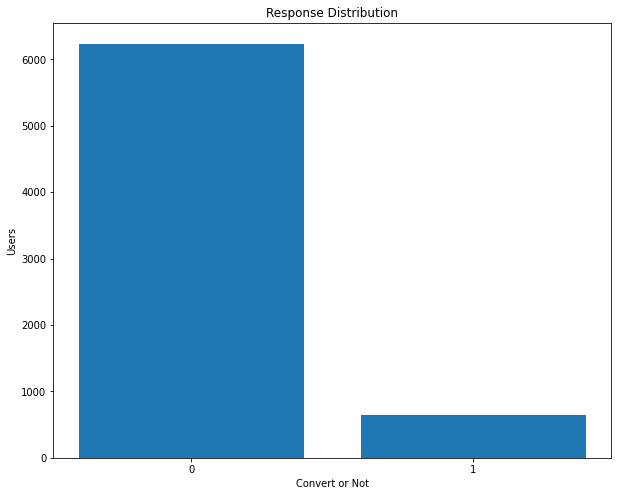

In [ ]:
plt.figure(figsize=(10,8))
x=range(2)
plt.bar(x,df_group_response['customer_id'])
plt.xticks(df_group_response.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('Users')
plt.show()

In [ ]:
response_rfm = pd.merge(df_response,df_rfm)
response_rfm.head(10)

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857
5,CS1117,0,258.0,17,1185
6,CS1118,1,3.0,15,1011
7,CS1119,0,12.0,15,1158
8,CS1120,0,11.0,24,1677
9,CS1121,0,42.0,26,1524


In [ ]:
response_clv = pd.merge(df_response,df_clv)
response_clv.head(10)

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077
5,CS1117,0,258.0,17,1185,1139,69.705882
6,CS1118,1,3.0,15,1011,1396,67.400000
7,CS1119,0,12.0,15,1158,1101,77.200000
8,CS1120,0,11.0,24,1677,1380,69.875000
9,CS1121,0,42.0,26,1524,1345,58.615385


# Creating train / test 

In [ ]:
X_rfm = response_rfm.drop(columns=['response','customer_id'])
y_rfm = response_rfm['response']

X_clv = response_clv.drop(columns=['response','customer_id'])
y_clv = response_clv['response']

In [ ]:
X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=10)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=10)

# Visualization

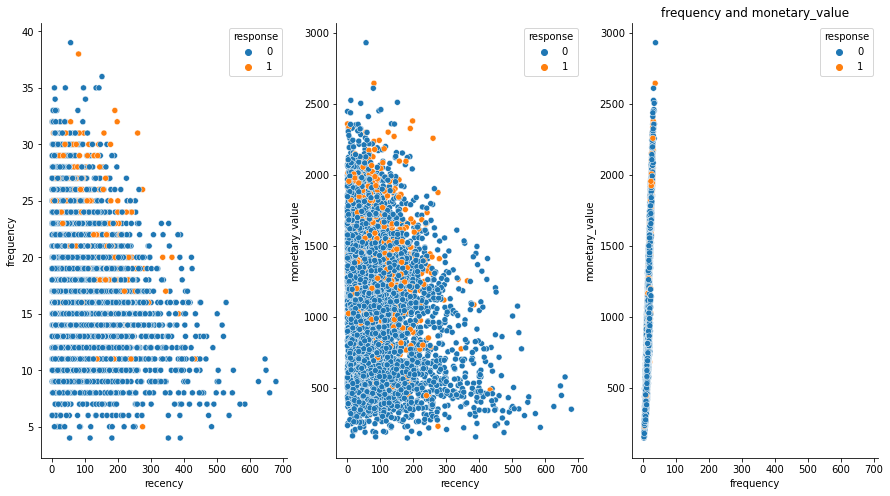

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15, 8), sharex=True)
col =0
for i, col_i in enumerate(response_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(response_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=response_rfm, x=col_i, y=col_j, hue='response',ax=axes[col])
      sns.despine()
      col = col+1

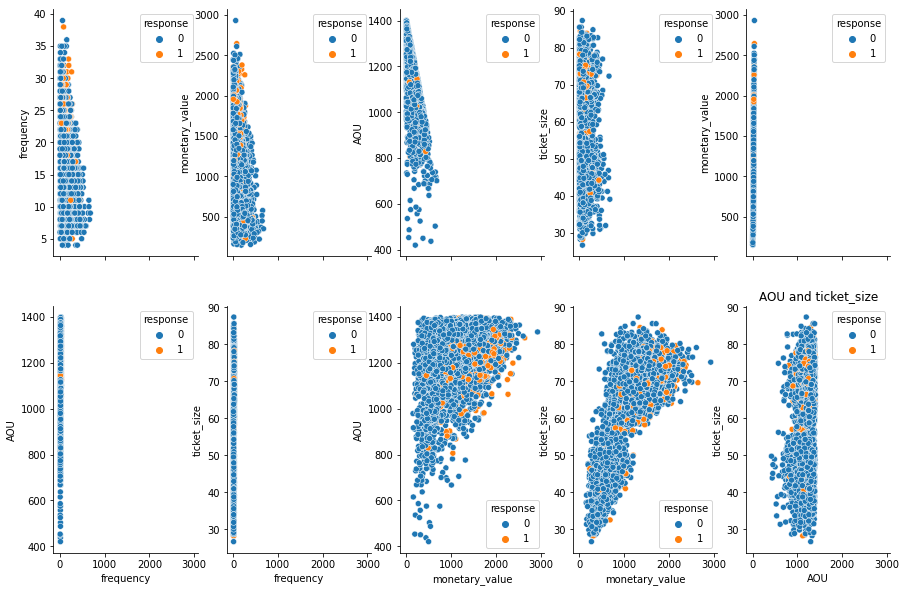

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(15, 10), sharex=True)
count =0
row = 0
for i, col_i in enumerate(response_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(response_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      
      if count==5:
        count = 0
        row = 1
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=response_clv, x=col_i, y=col_j, hue='response',ax=axes[row,count])
      sns.despine()
      count = count+1
      

# Imbalanc with SMOTE

In [ ]:
sm = SMOTE(random_state=10)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)
X_SMOTE_rfm = pd.DataFrame(X_SMOTE_rfm, columns=X_train_rfm.columns)


sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)
X_SMOTE_clv = pd.DataFrame(X_SMOTE_clv, columns=X_train_clv.columns)


#Note Error : https://stackoverflow.com/questions/66364406/attributeerror-smote-object-has-no-attribute-fit-sample

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
accuracy_models = {
  "SVR RFM": 0,
  "SVR CLV": 0,
  "Logistic Regression RFM": 0,
  "Logistic Regression CLV": 0,
  "XGBoost RFM": 0,
  "XGBoost CLV": 0,
  "XGBoost Tuning": 0
}

# Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
regr = SVR(C=1.0, epsilon=0.2)

In [ ]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(np.array(X_SMOTE_rfm))
X_test = sc_X.fit_transform(np.array(X_test_rfm))
y = sc_y.fit_transform(np.array(y_SMOTE_rfm).reshape(-1, 1))

In [ ]:
regr.fit(X, y.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = regr.predict(X)
y_pred = sc_y.inverse_transform(y_pred) 
y_pred = np.round(y_pred)
y_pred

array([1., 1., 1., ..., 0., 1., 1.])

In [ ]:
y_test = regr.predict(X_test)
y_test = sc_y.inverse_transform(y_test) 
y_test = np.round(y_test)
y_test

array([0., 1., 1., ..., 1., 1., 1.])

In [ ]:

report_train = classification_report(y_SMOTE_rfm, y_pred)
print('Training Set')
print('---------------------------------------------------------')
print(report_train) 

report_test = classification_report(y_test_rfm, y_test)
report_test_dict = classification_report(y_test_rfm, y_test,output_dict=True)
print('Test Set')
print('---------------------------------------------------------')
print(report_test) 
accuracy_models['SVR RFM'] = report_test_dict['accuracy']

Training Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.56      0.64      4373
           1       0.65      0.80      0.72      4373

    accuracy                           0.68      8746
   macro avg       0.69      0.68      0.68      8746
weighted avg       0.69      0.68      0.68      8746

Test Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.44      0.61      1864
           1       0.14      0.85      0.24       202

    accuracy                           0.48      2066
   macro avg       0.55      0.64      0.42      2066
weighted avg       0.88      0.48      0.57      2066



In [ ]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(np.array(X_SMOTE_clv))
X_test = sc_X.fit_transform(np.array(X_test_clv))
y = sc_y.fit_transform(np.array(y_SMOTE_clv).reshape(-1, 1))

In [ ]:
regr.fit(X, y.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = regr.predict(X)
y_pred = sc_y.inverse_transform(y_pred) 
y_pred = np.round(y_pred)
y_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
y_test = regr.predict(X_test)
y_test = sc_y.inverse_transform(y_test) 
y_test = np.round(y_test)
y_test

array([0., 1., 1., ..., 1., 1., 1.])

In [ ]:

report_train = classification_report(y_SMOTE_clv, y_pred)
print('Training Set')
print('---------------------------------------------------------')
print(report_train) 

report_test = classification_report(y_test_clv, y_test)
report_test_dict = classification_report(y_test_clv, y_test,output_dict=True)
print('Test Set')
print('---------------------------------------------------------')
print(report_test) 
accuracy_models['SVR CLV'] = report_test_dict['accuracy']

Training Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.57      0.65      4373
           1       0.66      0.83      0.73      4373

    accuracy                           0.70      8746
   macro avg       0.71      0.70      0.69      8746
weighted avg       0.71      0.70      0.69      8746

Test Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.44      0.60      1864
           1       0.14      0.84      0.24       202

    accuracy                           0.48      2066
   macro avg       0.55      0.64      0.42      2066
weighted avg       0.88      0.48      0.57      2066



# Logistic Regression

In [ ]:
print('Logistic Regression SMOTE RFM')

predicted_y = []
expected_y = []

model_lr_rfm = LogisticRegression(solver='liblinear', class_weight='balanced')
model_lr_rfm = model_lr_rfm.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = model_lr_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('Training Set')
print('---------------------------------------------------------')
print(report_train) 

predicted_y = []
expected_y = []
predictions = model_lr_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
report_test_dict = classification_report(expected_y, predicted_y,output_dict=True)
print('Test Set')
print('---------------------------------------------------------')
print(report_test) 
accuracy_models['Logistic Regression RFM'] = report_test_dict['accuracy']

Logistic Regression SMOTE RFM
Training Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      4373
           1       0.66      0.70      0.68      4373

    accuracy                           0.67      8746
   macro avg       0.67      0.67      0.67      8746
weighted avg       0.67      0.67      0.67      8746

Test Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1864
           1       0.17      0.68      0.27       202

    accuracy                           0.64      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.87      0.64      0.71      2066



In [ ]:
print('Logistic Regression SMOTE CLV')

predicted_y = []
expected_y = []

model_lr_clv = LogisticRegression(solver='liblinear', class_weight='balanced')
model_lr_clv = model_lr_clv.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = model_lr_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('Training Set')
print('---------------------------------------------------------')
print(report_train) 

predicted_y = []
expected_y = []

predictions = model_lr_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
report_test_dict = classification_report(expected_y, predicted_y,output_dict=True)
print('Test Set')
print('---------------------------------------------------------')
print(report_test) 
accuracy_models['Logistic Regression CLV'] = report_test_dict['accuracy']

Logistic Regression SMOTE CLV
Training Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      4373
           1       0.65      0.69      0.67      4373

    accuracy                           0.66      8746
   macro avg       0.66      0.66      0.66      8746
weighted avg       0.66      0.66      0.66      8746

Test Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1864
           1       0.17      0.69      0.27       202

    accuracy                           0.64      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.87      0.64      0.71      2066



# XGBoost

In [ ]:
print('XGBoost SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6,
 use_label_encoder=False)

X_SMOTE_rfm = X_SMOTE_rfm[['frequency', 'recency', 'monetary_value']]
X_test_rfm = X_test_rfm[['frequency', 'recency', 'monetary_value']]

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm, y_test_rfm)])

XGBoost SMOTE RFM
[0]	validation_0-auc:0.672809
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.684341
[2]	validation_0-auc:0.684049
[3]	validation_0-auc:0.684049
[4]	validation_0-auc:0.684049
[5]	validation_0-auc:0.684341
[6]	validation_0-auc:0.68412
Stopping. Best iteration:
[1]	validation_0-auc:0.684341



In [ ]:
predicted_y = []
expected_y = []

predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('Training Set')
print('---------------------------------------------------------')
print(report_train) 

predicted_y = []
expected_y = []

predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
report_test_dict = classification_report(expected_y, predicted_y,output_dict=True)
print('Test Set')
print('---------------------------------------------------------')
print(report_test) 
accuracy_models['XGBoost RFM'] = report_test_dict['accuracy']

Training Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      4373
           1       0.66      0.78      0.72      4373

    accuracy                           0.69      8746
   macro avg       0.70      0.69      0.69      8746
weighted avg       0.70      0.69      0.69      8746

Test Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      1864
           1       0.16      0.71      0.26       202

    accuracy                           0.60      2066
   macro avg       0.55      0.65      0.49      2066
weighted avg       0.87      0.60      0.68      2066



In [ ]:
print('XGBoost SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6,
 use_label_encoder=False
                             )

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv, y_test_clv)])

XGBoost SMOTE CLV
[0]	validation_0-auc:0.673725
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.689257
[2]	validation_0-auc:0.711071
[3]	validation_0-auc:0.712064
[4]	validation_0-auc:0.712064
[5]	validation_0-auc:0.710168
[6]	validation_0-auc:0.709536
[7]	validation_0-auc:0.708028
[8]	validation_0-auc:0.708249
Stopping. Best iteration:
[3]	validation_0-auc:0.712064



In [ ]:
predicted_y = []
expected_y = []

predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)

print('Training Set')
print('---------------------------------------------------------')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
report_test_dict = classification_report(expected_y, predicted_y,output_dict=True)
print('Test Set')
print('---------------------------------------------------------')
print(report_test) 
accuracy_models['XGBoost CLV'] = report_test_dict['accuracy']

Training Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.56      0.64      4373
           1       0.65      0.81      0.72      4373

    accuracy                           0.69      8746
   macro avg       0.70      0.69      0.68      8746
weighted avg       0.70      0.69      0.68      8746

Test Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.56      0.70      1864
           1       0.16      0.76      0.26       202

    accuracy                           0.58      2066
   macro avg       0.56      0.66      0.48      2066
weighted avg       0.88      0.58      0.66      2066



# Hyperparameter Tuning

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9, use_label_encoder=False))
])

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=10, shuffle=True)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score), 'F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.3min finished


In [ ]:
predicted_y = []
expected_y = []

predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_clv, predictions)))
print(confusion_matrix(y_test_clv,predictions))

Best AUC Score: 0.7120767065960414
Accuracy: 0.6181026137463698
[[1149  715]
 [  74  128]]


In [ ]:
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
report_test_dict = classification_report(expected_y, predicted_y,output_dict=True)
print('Test Set')
print('---------------------------------------------------------')
print(report_test)
accuracy_models['XGBoost Tuning'] = report_test_dict['accuracy']

Test Set
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.62      0.74      1864
           1       0.15      0.63      0.24       202

    accuracy                           0.62      2066
   macro avg       0.55      0.63      0.49      2066
weighted avg       0.86      0.62      0.70      2066



# Best Parameters

In [ ]:
xgb_model_clv_GS.best_params_

{'clf__colsample_bytree': 0.4,
 'clf__gamma': 0.0,
 'clf__learning_rate': 0.01,
 'clf__max_depth': 2,
 'clf__n_estimators': 300,
 'fs__k': 2,
 'fs__score_func': <function sklearn.feature_selection._univariate_selection.chi2>}

# Best Model

In [ ]:
accuracy_models

{'Logistic Regression CLV': 0.6369796708615683,
 'Logistic Regression RFM': 0.6374636979670861,
 'SVR CLV': 0.4791868344627299,
 'SVR RFM': 0.48112294288480156,
 'XGBoost CLV': 0.5769603097773476,
 'XGBoost RFM': 0.6035818005808326,
 'XGBoost Tuning': 0.6181026137463698}

In [ ]:
max_key = max(accuracy_models, key=accuracy_models.get)
print(max_key)

Logistic Regression RFM
